# Tests for Sparse Covariance Times Vector Function


In [1]:
import sys
from pathlib import Path

parent_dir = Path.cwd().parent
sys.path.insert(0, str(parent_dir))

In [2]:
#import from invcov and zeropad funcs for computing C^{-1} and zeropadding
from invcov import *
from utils import *
from zp_puregpu_funcs_py import *

/home/mike/corrcal_gpu_pipeline/pipeline/invcov.py:91: SyntaxWarning: invalid escape sequence '\D'
  """


hera_cal is not installed. Some gridding features unavailable.
pyfof is not installed. Some gridding features unavailable.


/home/mike/corrcal_gpu_pipeline/pipeline/utils.py:128: SyntaxWarning: invalid escape sequence '\D'
  """


In [3]:
import numpy as np
import cupy as cp
import seaborn as sns
import matplotlib.pyplot as plt
from cupyx.profiler import benchmark

## Define sparse covariance times data function

TODO: re-design function to handle only taking in as arguments: cov & data. Should also shift away from the xp thing since this is growing convoluted and besides some functions (eg. zeroPad - gpu version) is not cross compatible with np and cp..

UPDATE: This is done, but without the use of a class just yet. Instead, the outdated version below relies on both the regular and inverse matrices as arguments whereas the new version only requires one or the other and uses logic to determine the correct mathematical operations to perform. See utils.py for the correct function.

In [4]:
#note this might be a really good time to consider making a covariance class 
#this way, this function could in theory inherit all of the mattrices like N, Sig, Del,
#and also N_inv, Del_prime, Sig_prime

# def sparse_cov_times_vec(N, Del, Sig, N_inv, Del_prime, Sig_prime, vec, isinv, xp):
#     if vec.ndim == 2:
#         vec = vec.reshape(vec.shape[0], vec.shape[1], 1)
#         N = N.reshape(vec.shape[0], vec.shape[1], 1)
#         N_inv = N_inv.reshape(vec.shape[0], vec.shape[1], 1)
#     else:
#         pass
#     if isinv:
#         del_tmp = xp.transpose(Del_prime, [0, 2, 1]) @ vec
#         sig_tmp = xp.sum(xp.transpose(Sig_prime, [0, 2, 1]) @ vec, axis=0)
#         out = N_inv * vec - Del_prime @ del_tmp - Sig_prime @ sig_tmp
#     else:
#         del_tmp = xp.transpose(Del, [0, 2, 1]) @ vec
#         sig_tmp = xp.sum(xp.transpose(Sig, [0, 2, 1]) @ vec, axis=0)
#         out = N * vec + Del @ del_tmp + Sig @ sig_tmp
#     return out

## Test that $C^{-1}d$ works as expected

I will first test that things work using the inverse covariance. Regular covariance is to follow. It is important to test both since the $Cd$ version appears in the gradient calculation.

Start by simulating the main matrices and vectors using some randomly generated arrays, then zeropad where appropriate, manually compute cov times a vector and compare to the output of the function above.

In [5]:
#the main parametes describing our problem.
n_bl = 20
n_eig = 3
n_src = 5
xp = cp  #run things on the gpu using cupy

#random array of edges for the diffuse matrix
edges = xp.unique(xp.random.randint(1, n_bl-1, size = 4))
edges = xp.concatenate((xp.array([0]), edges, xp.array([n_bl])))
print(f"The edges of the redundant blocks have indices{edges}")

#some random noise, diffuse, and source covariance matrices
if xp == np:
    sim_noise_mat = (xp.random.rand(n_bl)**2).astype('float64')   #in principle this is squared since is a variance
    sim_diff_mat = xp.random.rand(n_bl, n_eig).astype('float64')
    sim_src_mat = xp.random.rand(n_bl, n_src).astype('float64')
    sim_data_vec = xp.random.rand(n_bl).astype('float64')
    print(type(sim_noise_mat))
    print(type(sim_diff_mat))
    print(type(sim_src_mat))
    print(type(sim_data_vec))
elif xp == cp:
    sim_noise_mat = xp.random.rand(n_bl, dtype = 'float64')**2   #in principle this is squared since is a variance
    sim_diff_mat = xp.random.rand(n_bl, n_eig, dtype = 'float64')
    sim_src_mat = xp.random.rand(n_bl, n_src, dtype = 'float64')
    sim_data_vec = xp.random.rand(n_bl, dtype = 'float64')
    print(type(sim_noise_mat))
    print(type(sim_diff_mat))
    print(type(sim_src_mat))
    print(type(sim_data_vec))

The edges of the redundant blocks have indices[ 0  5 12 17 20]
<class 'cupy.ndarray'>
<class 'cupy.ndarray'>
<class 'cupy.ndarray'>
<class 'cupy.ndarray'>


In [6]:
#zeropad the noise, diff, source mats
zp_sim_noise_mat_inv, largest_block, n_blocks = zeroPad(sim_noise_mat, edges, return_inv=True)  #return inverse set to True to get around div by 0 issue
zp_sim_diff_mat, largest_block, n_blocks = zeroPad(sim_diff_mat, edges, return_inv=False)
zp_sim_src_mat, largest_block, n_blocks = zeroPad(sim_src_mat, edges, return_inv=False)
zp_sim_data_vec, largest_block, n_blocks = zeroPad(sim_data_vec, edges, return_inv=False)

In [7]:
#find inverse components, noting the result will still be a set of zeropadded matrices
#Note we feed the inverse noise components to the inverse cov routine as can be seen by the N_is_inv=True
logdet, N_inv, Del_p, Sig_p = inverse_covariance(zp_sim_noise_mat_inv, zp_sim_diff_mat, zp_sim_src_mat, xp = xp , ret_det = True, N_is_inv=True)

In [8]:
out_inv = sparse_cov_times_vec(N_inv, Del_p, Sig_p, zp_sim_data_vec, isinv=True)
out_reshape = out_inv.reshape(n_blocks*largest_block)

To test the accuracy of the sparse mat mul routine, we need the diffuse matrix in its dense form, which first requires reshaping the zeropadded arrays such that 2D -> 1D and 3D -> 2D.

In [9]:
N_inv = N_inv.reshape(n_blocks * largest_block)
Del_p = Del_p.reshape(n_blocks * largest_block, n_eig)
Sig_p = Sig_p.reshape(n_blocks * largest_block, n_src)

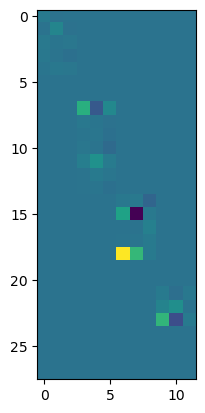

In [10]:
#convert sparse things to dense things to visualize what we're really working with
Del_p_dense = sparden_convert(Del_p, largest_block, n_blocks, n_bl=n_bl, n_eig=n_eig, edges=edges, xp = cp, zeroPad=True)
plt.imshow(cp.asnumpy(Del_p_dense))
plt.show()

Now test the custom routine against the manual $C^{-1} \times d$ calculation.

In [11]:
#first assemble the full dense covariance
dense_cov_inv = cp.diag(N_inv) - Del_p_dense @ Del_p_dense.T - Sig_p @ Sig_p.T

#ensure the data array can be suitably multiplied by the inv cov
zp_sim_data_vec = zp_sim_data_vec.reshape(n_blocks*largest_block)

#manually perform the calculation
dense_cov_inv_times_vec = dense_cov_inv @ zp_sim_data_vec

#compare the two methods
assert np.allclose(dense_cov_inv_times_vec, out_reshape)

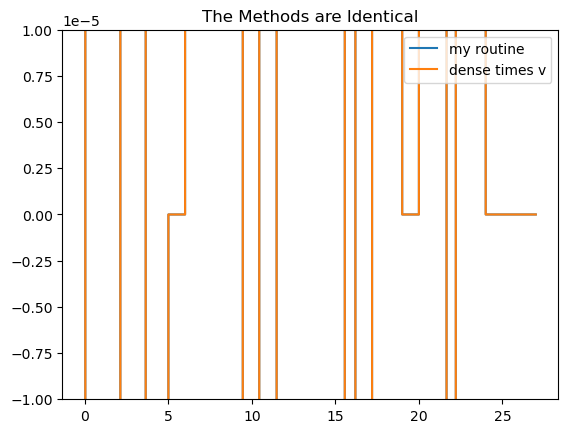

In [12]:
#Check graphically whether the two methods return the same result
plt.plot(cp.asnumpy(out_reshape), label = "my routine")
plt.plot(cp.asnumpy(dense_cov_inv_times_vec), label = "dense times v")
plt.title("The Methods are Identical")
plt.ylim(-0.00001, 0.00001)
plt.legend()
plt.show()

### Benchmarking sparse cov times vec

It is useful to get a quick sense of how quick things will run for this simple routine while we're at it.

In [13]:
N_inv = N_inv.reshape(n_blocks, largest_block)
Del_p = Del_p.reshape(n_blocks, largest_block, n_eig)
Sig_p = Sig_p.reshape(n_blocks, largest_block, n_src)
zp_sim_data_vec = zp_sim_data_vec.reshape(n_blocks, largest_block)

In [14]:
print(benchmark(sparse_cov_times_vec, (N_inv, Del_p, Sig_p, zp_sim_data_vec, True), n_repeat=100))

sparse_cov_times_vec:    CPU:  1050.963 us   +/- 482.091 (min:   600.664 / max:  3336.209) us     GPU-0:  1091.226 us   +/- 558.891 (min:   111.616 / max:  3501.056) us


## Test for Accuracy of $Cd$ Routine

Note we can just re-use the simulated arrays in the previous part, but just to be safe, I'll run things again.

In [15]:
#the main parametes describing our problem.
n_bl = 20
n_eig = 3
n_src = 5
xp = cp  #run things on the gpu using cupy

#random array of edges for the diffuse matrix
edges = xp.unique(xp.random.randint(1, n_bl - 1, size=4))
edges = xp.concatenate((xp.array([0]), edges, xp.array([n_bl])))
print(f"The edges of the redundant blocks have indices{edges}")

sim_noise_mat = xp.random.rand(n_bl, dtype = 'float64')**2   #in principle this is squared since is a variance
sim_diff_mat = xp.random.rand(n_bl, n_eig, dtype = 'float64')
sim_src_mat = xp.random.rand(n_bl, n_src, dtype = 'float64')
sim_data_vec = xp.random.rand(n_bl, dtype = 'float64')

The edges of the redundant blocks have indices[ 0  3  6 11 16 20]


Once again, we zeropad as the sparse cov times vector function expects things that way. We also will need to calculate the inverse components as the routine expects these at the present time.

In [16]:
#zeropad the noise, diff, source mats
zp_sim_noise_mat, largest_block, n_blocks = zeroPad(sim_noise_mat, edges, return_inv=False)  #Needs to be set s.t. return_inv=False if want to construct C = N + DD^T + SS^T
zp_sim_diff_mat, largest_block, n_blocks = zeroPad(sim_diff_mat, edges, return_inv=False)
zp_sim_src_mat, largest_block, n_blocks = zeroPad(sim_src_mat, edges, return_inv=False)
zp_sim_data_vec, largest_block, n_blocks = zeroPad(sim_data_vec, edges, return_inv=False)

In [17]:
zp_cov_times_vec = sparse_cov_times_vec(zp_sim_noise_mat, zp_sim_diff_mat, zp_sim_src_mat, zp_sim_data_vec, isinv=False)

In [18]:
cov_times_vec = undo_zeroPad(zp_cov_times_vec, edges, True)

### ZP Sanity check...

Had to double check for piece of mind that the zp and undo zp functions are inverses of eachother.

In [19]:
zpa, _, _ = zeroPad(sim_diff_mat, edges, return_inv=False)
uzpa = undo_zeroPad(zpa, edges, True)
assert cp.allclose(sim_diff_mat, uzpa)

#### Now, back to the testing action

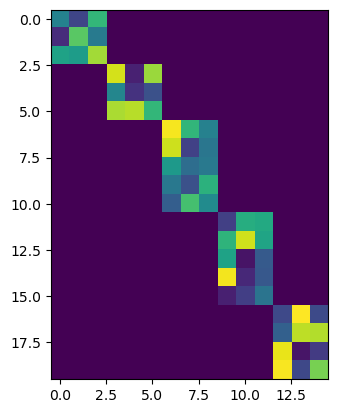

In [20]:
diffuse_dense = sparden_convert(sim_diff_mat, largest_block, n_blocks, n_bl = n_bl, n_eig = n_eig, edges=edges, xp = cp, zeroPad=False)
plt.imshow(cp.asnumpy(diffuse_dense))
plt.show()

I'll finally assert once more that the manually calculated $C\times d$ yields the same answer as the function at the start of the notebook.

In [21]:
dense_cov = cp.diag(sim_noise_mat) + diffuse_dense @ diffuse_dense.T + sim_src_mat @ sim_src_mat.T
dense_cov_times_vec = dense_cov @ sim_data_vec
dense_cov_times_vec = dense_cov_times_vec.reshape(len(dense_cov_times_vec), 1)

assert np.allclose(dense_cov_times_vec, cov_times_vec)